In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import copy
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.0005 # 0.096779
epochs = 100
epochs_pretrain = 3 #3
epochs_optimal_lr = 3 #5
patience_teacher = 3
patience_student = 5
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
lmda = 3
batch_size = 76
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
lmda_list_student = [15,10,5,3,0]
lmda_list_teacher = [0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16 #len(class_labels)
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(16):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
len(train_dataset)

10324

# Start Training Process

In [12]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [13]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)

# Load teacher
# teacher_model = torch.load('teacher_model_ckd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [14]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [15]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [16]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [17]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        adversary_output = adv(student_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [18]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [19]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [20]:
def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            adversary_output = adv(teacher_outputs_detached)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                adversary_output_val = adv(teacher_outputs_detached_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
        
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizers, optimizera, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        student.train()
        student.to(device)
        adv.train()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizers.zero_grad()
            optimizera.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(studentached)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizers.step()
            optimizera.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        adv.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   

                val_adversary_output = adv(val_studentached)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
    
        file_path = os.path.join(output_dir, f'validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epoch}***********')
            
            file.write("Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nVal Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.48it/s]


*****Epoch 1/100*****
*****Train Loss:  1.573693 Val Loss:  1.198609*****
*****Validation Accuracy: 63.15%*****
*****Total Avg Disparity: 0.1579134980149971*****

Class Team_Sports: Recall Difference = 0.0786360716996557
Class Celebration: Recall Difference = -0.042500505356781904
Class Parade: Recall Difference = 0.1318970047293746
Class Waiter_Or_Waitress: Recall Difference = -0.3163265306122448
Class Individual_Sports: Recall Difference = -0.07205032550654655
Class Surgeons: Recall Difference = -0.026607538802660757
Class Spa: Recall Difference = 0.21276595744680837
Class Law_Enforcement: Recall Difference = 0.15893500755726087
Class Business: Recall Difference = -0.02941176470588236
Class Dresses: Recall Difference = -0.7159509202453987
Class Water Activities: Recall Difference = 0.06388511985526912
Class Picnic: Recall Difference = -0.41830065359477125
Class Rescue: Recall Difference = 0.012405063291139218
Class Cheering: Recall Difference = 0.0634206219312603
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.48it/s]


*****Epoch 2/100*****
*****Train Loss:  0.835941 Val Loss:  1.192453*****
*****Validation Accuracy: 64.73%*****
*****Total Avg Disparity: 0.13494515127105647*****

Class Team_Sports: Recall Difference = 0.07335785601681566
Class Celebration: Recall Difference = -0.06989084293511216
Class Parade: Recall Difference = 0.12319729082734843
Class Waiter_Or_Waitress: Recall Difference = -0.2189952904238618
Class Individual_Sports: Recall Difference = -0.013312852022529298
Class Surgeons: Recall Difference = -0.1359940872135993
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.07650273224043702
Class Business: Recall Difference = -0.04006820119352095
Class Dresses: Recall Difference = -0.701840490797546
Class Water Activities: Recall Difference = 0.08638625056535498
Class Picnic: Recall Difference = -0.3333333333333333
Class Rescue: Recall Difference = 0.01898734177215189
Class Cheering: Recall Difference = -0.02761865793780688
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 3/100*****
*****Train Loss:  0.427166 Val Loss:  1.370008*****
*****Validation Accuracy: 63.12%*****
*****Total Avg Disparity: 0.1514740375374728*****

Class Team_Sports: Recall Difference = 0.06847667425702098
Class Celebration: Recall Difference = -0.12431776834445118
Class Parade: Recall Difference = 0.04805278215682829
Class Waiter_Or_Waitress: Recall Difference = -0.21114599686028268
Class Individual_Sports: Recall Difference = -0.07318411235461908
Class Surgeons: Recall Difference = -0.026607538802660757
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.24311126613184514
Class Business: Recall Difference = 0.03260869565217389
Class Dresses: Recall Difference = -0.705521472392638
Class Water Activities: Recall Difference = -0.01922207146087751
Class Picnic: Recall Difference = -0.2026143790849672
Class Rescue: Recall Difference = 0.07037974683544296
Class Cheering: Recall Difference = -0.07037643207855981
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.47it/s]


*****Epoch 4/100*****
*****Train Loss:  0.211100 Val Loss:  1.521160*****
*****Validation Accuracy: 64.33%*****
*****Total Avg Disparity: 0.15807420318888107*****

Class Team_Sports: Recall Difference = 0.08031762713843638
Class Celebration: Recall Difference = -0.06296745502324641
Class Parade: Recall Difference = 0.06399252642027209
Class Waiter_Or_Waitress: Recall Difference = -0.22135007849293575
Class Individual_Sports: Recall Difference = -0.042535293687367526
Class Surgeons: Recall Difference = -0.06356245380635617
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.2404371584699454
Class Business: Recall Difference = 0.004262574595055468
Class Dresses: Recall Difference = -0.7282208588957055
Class Water Activities: Recall Difference = 0.04138398914518315
Class Picnic: Recall Difference = -0.26143790849673204
Class Rescue: Recall Difference = 0.03772151898734172
Class Cheering: Recall Difference = 0.06198854337152204
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.48it/s]


*****Epoch 5/100*****
*****Train Loss:  0.149551 Val Loss:  1.643420*****
*****Validation Accuracy: 64.13%*****
*****Total Avg Disparity: 0.17103066426902824*****

Class Team_Sports: Recall Difference = 0.06841828691539675
Class Celebration: Recall Difference = -0.0448756822316555
Class Parade: Recall Difference = 0.09149296432533416
Class Waiter_Or_Waitress: Recall Difference = -0.17268445839874402
Class Individual_Sports: Recall Difference = -0.08280301367858967
Class Surgeons: Recall Difference = -0.13673318551367325
Class Spa: Recall Difference = -0.2836879432624115
Class Law_Enforcement: Recall Difference = 0.07964190210440647
Class Business: Recall Difference = 0.03367433930093777
Class Dresses: Recall Difference = -0.5791411042944785
Class Water Activities: Recall Difference = 0.07858435097241079
Class Picnic: Recall Difference = -0.6078431372549019
Class Rescue: Recall Difference = 0.030379746835442978
Class Cheering: Recall Difference = -0.13052373158756142
Class Performance_A

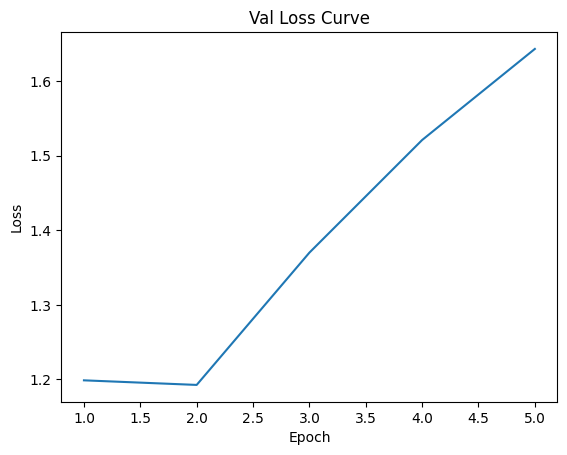

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [21]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
#     teacher_model = torch.load('teacher_model_ckd_wider_lambda02.pth')
#     teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda02.pth'))
    
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=learning_rate)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_ckd_wider_lambda{i}2.pth')
    torch.save(teacher_model, f'teacher_model_ckd_wider_lambda{i}2.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 0: loss - 0.6540927334743387


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 1: loss - 0.3921015188097954


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 2: loss - 0.26178907208582936


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.4848418031983516


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.4846458110739203


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.48470095588880424


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 1/100*****
*****Train Loss: -6.757639 Val Loss: -6.088445*****
*****Validation Accuracy: 63.55%*****
*****Total Avg Disparity: 0.11919522436223705*****

Class Team_Sports: Recall Difference = 0.033514334092368814
Class Celebration: Recall Difference = -0.0845967252880534
Class Parade: Recall Difference = 0.04822794418170129
Class Waiter_Or_Waitress: Recall Difference = -0.14207221350078492
Class Individual_Sports: Recall Difference = -0.06846609611586574
Class Surgeons: Recall Difference = -0.07538802660753874
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.11021974189047778
Class Business: Recall Difference = 0.017263427109974416
Class Dresses: Recall Difference = -0.5730061349693252
Class Water Activities: Recall Difference = 0.04828132066938018
Class Picnic: Recall Difference = -0.03267973856209161
Class Rescue: Recall Difference = -0.00025316455696200446
Class Cheering: Recall Difference = -0.07283142389525371
Class Perform

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 2/100*****
*****Train Loss: -6.782148 Val Loss: -6.103843*****
*****Validation Accuracy: 63.87%*****
*****Total Avg Disparity: 0.13179374306917194*****

Class Team_Sports: Recall Difference = 0.02251415893034392
Class Celebration: Recall Difference = -0.10420456842530834
Class Parade: Recall Difference = 0.05686927074210313
Class Waiter_Or_Waitress: Recall Difference = -0.14207221350078503
Class Individual_Sports: Recall Difference = -0.08170580059980981
Class Surgeons: Recall Difference = -0.07538802660753874
Class Spa: Recall Difference = -0.3687943262411347
Class Law_Enforcement: Recall Difference = 0.11021974189047778
Class Business: Recall Difference = -0.02301790281329924
Class Dresses: Recall Difference = -0.6546012269938651
Class Water Activities: Recall Difference = 0.026006331976481167
Class Picnic: Recall Difference = -0.05228758169934644
Class Rescue: Recall Difference = -0.05291139240506326
Class Cheering: Recall Difference = -0.09206219312602293
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 3/100*****
*****Train Loss: -6.787885 Val Loss: -6.101877*****
*****Validation Accuracy: 64.13%*****
*****Total Avg Disparity: 0.11914207614717057*****

Class Team_Sports: Recall Difference = 0.02829450575115322
Class Celebration: Recall Difference = -0.09930260764099463
Class Parade: Recall Difference = 0.0438488935598762
Class Waiter_Or_Waitress: Recall Difference = -0.16248037676609117
Class Individual_Sports: Recall Difference = -0.05164216224124063
Class Surgeons: Recall Difference = -0.07538802660753885
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.11021974189047778
Class Business: Recall Difference = -0.02301790281329924
Class Dresses: Recall Difference = -0.5607361963190183
Class Water Activities: Recall Difference = 0.033355947535052
Class Picnic: Recall Difference = 0.006535947712418166
Class Rescue: Recall Difference = 0.012405063291139218
Class Cheering: Recall Difference = -0.07283142389525371
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 4/100*****
*****Train Loss: -6.773028 Val Loss: -6.091504*****
*****Validation Accuracy: 63.67%*****
*****Total Avg Disparity: 0.1233096277720331*****

Class Team_Sports: Recall Difference = 0.03379459333216561
Class Celebration: Recall Difference = -0.10420456842530823
Class Parade: Recall Difference = 0.0482279441817014
Class Waiter_Or_Waitress: Recall Difference = -0.14207221350078492
Class Individual_Sports: Recall Difference = -0.0924584887718527
Class Surgeons: Recall Difference = -0.0509977827050998
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.11021974189047778
Class Business: Recall Difference = 0.027067348678601888
Class Dresses: Recall Difference = -0.5668711656441718
Class Water Activities: Recall Difference = 0.04093170511080957
Class Picnic: Recall Difference = -0.05228758169934644
Class Rescue: Recall Difference = -0.020253164556962078
Class Cheering: Recall Difference = -0.08244680851063835
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 5/100*****
*****Train Loss: -6.762884 Val Loss: -6.069641*****
*****Validation Accuracy: 63.90%*****
*****Total Avg Disparity: 0.12357157365965565*****

Class Team_Sports: Recall Difference = 0.021393121971156726
Class Celebration: Recall Difference = -0.0987972508591064
Class Parade: Recall Difference = 0.07993227068371578
Class Waiter_Or_Waitress: Recall Difference = -0.14207221350078503
Class Individual_Sports: Recall Difference = -0.06846609611586574
Class Surgeons: Recall Difference = -0.07538802660753874
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.11731194047203808
Class Business: Recall Difference = -0.024083546462063066
Class Dresses: Recall Difference = -0.6361963190184049
Class Water Activities: Recall Difference = 0.026006331976481167
Class Picnic: Recall Difference = -0.05228758169934644
Class Rescue: Recall Difference = -0.014936708860759429
Class Cheering: Recall Difference = -0.042962356792143996
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 6/100*****
*****Train Loss: -6.757559 Val Loss: -6.063101*****
*****Validation Accuracy: 63.61%*****
*****Total Avg Disparity: 0.1313241235681322*****

Class Team_Sports: Recall Difference = 0.023973842470952356
Class Celebration: Recall Difference = -0.09440064685668081
Class Parade: Recall Difference = 0.06842996438372162
Class Waiter_Or_Waitress: Recall Difference = -0.152276295133438
Class Individual_Sports: Recall Difference = -0.07040450588837688
Class Surgeons: Recall Difference = -0.07538802660753874
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.13149633763515867
Class Business: Recall Difference = 0.015132139812446765
Class Dresses: Recall Difference = -0.6484662576687117
Class Water Activities: Recall Difference = 0.04093170511080957
Class Picnic: Recall Difference = -0.05228758169934644
Class Rescue: Recall Difference = -0.0329113924050633
Class Cheering: Recall Difference = -0.10270049099836331
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.42it/s]


*****Epoch 7/100*****
*****Train Loss: -6.749774 Val Loss: -6.142921*****
*****Validation Accuracy: 64.10%*****
*****Total Avg Disparity: 0.12811418471812727*****

Class Team_Sports: Recall Difference = 0.024534360950546064
Class Celebration: Recall Difference = -0.0889933292904791
Class Parade: Recall Difference = 0.03374788345886626
Class Waiter_Or_Waitress: Recall Difference = -0.20879120879120883
Class Individual_Sports: Recall Difference = -0.0648818667251847
Class Surgeons: Recall Difference = -0.07538802660753874
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.11021974189047778
Class Business: Recall Difference = -0.036018755328218244
Class Dresses: Recall Difference = -0.6177914110429448
Class Water Activities: Recall Difference = 0.04093170511080957
Class Picnic: Recall Difference = -0.09150326797385622
Class Rescue: Recall Difference = -0.0075949367088608
Class Cheering: Recall Difference = -0.07385433715220951
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 8/100*****
*****Train Loss: -6.769886 Val Loss: -6.090517*****
*****Validation Accuracy: 63.90%*****
*****Total Avg Disparity: 0.12043340621636917*****

Class Team_Sports: Recall Difference = 0.03497401763297725
Class Celebration: Recall Difference = -0.09980796442288253
Class Parade: Recall Difference = 0.06113154668067966
Class Waiter_Or_Waitress: Recall Difference = -0.12166405023547877
Class Individual_Sports: Recall Difference = -0.06846609611586574
Class Surgeons: Recall Difference = -0.07538802660753874
Class Spa: Recall Difference = -0.3687943262411347
Class Law_Enforcement: Recall Difference = 0.11731194047203797
Class Business: Recall Difference = -0.03495311167945436
Class Dresses: Recall Difference = -0.5668711656441718
Class Water Activities: Recall Difference = 0.026006331976481167
Class Picnic: Recall Difference = -0.05228758169934644
Class Rescue: Recall Difference = -0.020253164556962078
Class Cheering: Recall Difference = -0.06219312602291316
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 9/100*****
*****Train Loss: -6.800527 Val Loss: -6.094592*****
*****Validation Accuracy: 63.78%*****
*****Total Avg Disparity: 0.12394089693702355*****

Class Team_Sports: Recall Difference = 0.035814795352367645
Class Celebration: Recall Difference = -0.10961188599151006
Class Parade: Recall Difference = 0.06118993402230399
Class Waiter_Or_Waitress: Recall Difference = -0.1601255886970172
Class Individual_Sports: Recall Difference = -0.08583863652988089
Class Surgeons: Recall Difference = -0.07538802660753874
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.10801069643064753
Class Business: Recall Difference = -0.057757885763000893
Class Dresses: Recall Difference = -0.5484662576687116
Class Water Activities: Recall Difference = 0.04093170511080957
Class Picnic: Recall Difference = -0.05228758169934644
Class Rescue: Recall Difference = -0.04556962025316458
Class Cheering: Recall Difference = -0.05257774140752869
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 10/100*****
*****Train Loss: -6.752074 Val Loss: -6.106005*****
*****Validation Accuracy: 63.87%*****
*****Total Avg Disparity: 0.12526953562774526*****

Class Team_Sports: Recall Difference = 0.018473754889939964
Class Celebration: Recall Difference = -0.0845967252880534
Class Parade: Recall Difference = 0.052548607461902264
Class Waiter_Or_Waitress: Recall Difference = -0.16248037676609095
Class Individual_Sports: Recall Difference = -0.0817058005998097
Class Surgeons: Recall Difference = -0.07538802660753874
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.09603534472735731
Class Business: Recall Difference = -0.027280477408354653
Class Dresses: Recall Difference = -0.6361963190184049
Class Water Activities: Recall Difference = 0.05585707824513797
Class Picnic: Recall Difference = -0.05228758169934644
Class Rescue: Recall Difference = -0.0075949367088608
Class Cheering: Recall Difference = -0.07385433715220951
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 11/100*****
*****Train Loss: -6.768188 Val Loss: -6.096623*****
*****Validation Accuracy: 63.64%*****
*****Total Avg Disparity: 0.12822701217673887*****

Class Team_Sports: Recall Difference = 0.019372919950954803
Class Celebration: Recall Difference = -0.06448352536891044
Class Parade: Recall Difference = 0.058328954282711565
Class Waiter_Or_Waitress: Recall Difference = -0.17268445839874402
Class Individual_Sports: Recall Difference = -0.06543047326457474
Class Surgeons: Recall Difference = -0.07538802660753874
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.11731194047203808
Class Business: Recall Difference = -0.007672634271099765
Class Dresses: Recall Difference = -0.6239263803680982
Class Water Activities: Recall Difference = 0.033582089552238736
Class Picnic: Recall Difference = -0.05228758169934644
Class Rescue: Recall Difference = -0.06025316455696211
Class Cheering: Recall Difference = -0.08142389525368238
Class Perfo

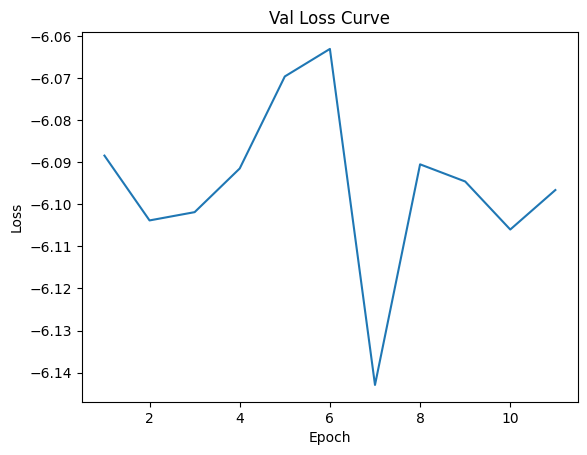

Student weights and architecture saved and exported for lambda: 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 0: loss - 0.6556357228580643


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 1: loss - 0.3967112112132942


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 2: loss - 0.26124083064496517


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.3535961184431525


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:41<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.35364041597965884


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.3535591997206211


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 1/100*****
*****Train Loss: -2.926425 Val Loss: -2.366727*****
*****Validation Accuracy: 64.42%*****
*****Total Avg Disparity: 0.17276893374042637*****

Class Team_Sports: Recall Difference = 0.061458515793775814
Class Celebration: Recall Difference = -0.04790782292298362
Class Parade: Recall Difference = 0.07561160740351491
Class Waiter_Or_Waitress: Recall Difference = -0.3265306122448979
Class Individual_Sports: Recall Difference = -0.18568502669885156
Class Surgeons: Recall Difference = -0.13008130081300806
Class Spa: Recall Difference = -0.49645390070921996
Class Law_Enforcement: Recall Difference = 0.2325311010347635
Class Business: Recall Difference = 0.01321398124467188
Class Dresses: Recall Difference = -0.5668711656441718
Class Water Activities: Recall Difference = 0.1086612392582541
Class Picnic: Recall Difference = -0.2875816993464052
Class Rescue: Recall Difference = 0.05645569620253166
Class Cheering: Recall Difference = -0.003477905073649812
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 2/100*****
*****Train Loss: -2.948466 Val Loss: -2.402199*****
*****Validation Accuracy: 64.21%*****
*****Total Avg Disparity: 0.16168404592212113*****

Class Team_Sports: Recall Difference = 0.06347871781397785
Class Celebration: Recall Difference = -0.008186779866585836
Class Parade: Recall Difference = 0.07415192386290648
Class Waiter_Or_Waitress: Recall Difference = -0.31632653061224514
Class Individual_Sports: Recall Difference = -0.1432228805500695
Class Surgeons: Recall Difference = -0.13008130081300817
Class Spa: Recall Difference = -0.49645390070921996
Class Law_Enforcement: Recall Difference = 0.22764794791303333
Class Business: Recall Difference = 0.02728047740835471
Class Dresses: Recall Difference = -0.5730061349693252
Class Water Activities: Recall Difference = 0.07835820895522383
Class Picnic: Recall Difference = -0.21568627450980393
Class Rescue: Recall Difference = 0.036455696202531584
Class Cheering: Recall Difference = -0.005523731587561365
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 3/100*****
*****Train Loss: -2.910858 Val Loss: -2.365766*****
*****Validation Accuracy: 64.16%*****
*****Total Avg Disparity: 0.1676776430512883*****

Class Team_Sports: Recall Difference = 0.06493840135458628
Class Celebration: Recall Difference = -0.01748534465332524
Class Parade: Recall Difference = 0.07993227068371578
Class Waiter_Or_Waitress: Recall Difference = -0.2598116169544741
Class Individual_Sports: Recall Difference = -0.16886109282422634
Class Surgeons: Recall Difference = -0.13008130081300806
Class Spa: Recall Difference = -0.49645390070921996
Class Law_Enforcement: Recall Difference = 0.22055574933147293
Class Business: Recall Difference = 0.03815004262574595
Class Dresses: Recall Difference = -0.5668711656441718
Class Water Activities: Recall Difference = 0.1013116236996835
Class Picnic: Recall Difference = -0.30718954248366015
Class Rescue: Recall Difference = 0.031139240506329102
Class Cheering: Recall Difference = 0.025368248772504043
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 4/100*****
*****Train Loss: -2.920048 Val Loss: -2.384673*****
*****Validation Accuracy: 64.30%*****
*****Total Avg Disparity: 0.16735118998272142*****

Class Team_Sports: Recall Difference = 0.06465814211478971
Class Celebration: Recall Difference = -0.046897109359207545
Class Parade: Recall Difference = 0.08571261750452508
Class Waiter_Or_Waitress: Recall Difference = -0.2496075353218209
Class Individual_Sports: Recall Difference = -0.16527686343354542
Class Surgeons: Recall Difference = -0.13008130081300806
Class Spa: Recall Difference = -0.4539007092198583
Class Law_Enforcement: Recall Difference = 0.22497384025113365
Class Business: Recall Difference = 0.02728047740835471
Class Dresses: Recall Difference = -0.5914110429447853
Class Water Activities: Recall Difference = 0.0863862505653551
Class Picnic: Recall Difference = -0.30718954248366015
Class Rescue: Recall Difference = 0.03645569620253164
Class Cheering: Recall Difference = 0.014729950900163657
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 5/100*****
*****Train Loss: -2.963002 Val Loss: -2.384560*****
*****Validation Accuracy: 64.50%*****
*****Total Avg Disparity: 0.1611391956752968*****

Class Team_Sports: Recall Difference = 0.055678168972966735
Class Celebration: Recall Difference = -0.06261370527592486
Class Parade: Recall Difference = 0.0871723010451334
Class Waiter_Or_Waitress: Recall Difference = -0.21114599686028268
Class Individual_Sports: Recall Difference = -0.15507278180089223
Class Surgeons: Recall Difference = -0.13008130081300806
Class Spa: Recall Difference = -0.49645390070921996
Class Law_Enforcement: Recall Difference = 0.23206603883269394
Class Business: Recall Difference = 0.025149190110826947
Class Dresses: Recall Difference = -0.5668711656441718
Class Water Activities: Recall Difference = 0.08616010854816825
Class Picnic: Recall Difference = -0.23529411764705882
Class Rescue: Recall Difference = 0.043797468354430436
Class Cheering: Recall Difference = 0.006137479541734769
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 6/100*****
*****Train Loss: -2.914239 Val Loss: -2.401156*****
*****Validation Accuracy: 64.39%*****
*****Total Avg Disparity: 0.171310886296207*****

Class Team_Sports: Recall Difference = 0.05741811175337186
Class Celebration: Recall Difference = -0.01900141499898933
Class Parade: Recall Difference = 0.07269224032229804
Class Waiter_Or_Waitress: Recall Difference = -0.2598116169544741
Class Individual_Sports: Recall Difference = -0.18264940384756057
Class Surgeons: Recall Difference = -0.13008130081300806
Class Spa: Recall Difference = -0.49645390070921974
Class Law_Enforcement: Recall Difference = 0.23915823741425413
Class Business: Recall Difference = 0.016410912190963356
Class Dresses: Recall Difference = -0.5791411042944785
Class Water Activities: Recall Difference = 0.08616010854816847
Class Picnic: Recall Difference = -0.30718954248366015
Class Rescue: Recall Difference = 0.08177215189873421
Class Cheering: Recall Difference = 0.04357610474631757
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 7/100*****
*****Train Loss: -2.917770 Val Loss: -2.317804*****
*****Validation Accuracy: 64.24%*****
*****Total Avg Disparity: 0.16076775890907072*****

Class Team_Sports: Recall Difference = 0.05741811175337164
Class Celebration: Recall Difference = -0.02339801900141497
Class Parade: Recall Difference = 0.09149296432533427
Class Waiter_Or_Waitress: Recall Difference = -0.2496075353218209
Class Individual_Sports: Recall Difference = -0.16169263404286427
Class Surgeons: Recall Difference = -0.10569105691056901
Class Spa: Recall Difference = -0.4751773049645391
Class Law_Enforcement: Recall Difference = 0.2227647947913033
Class Business: Recall Difference = 0.01534526854219953
Class Dresses: Recall Difference = -0.5607361963190184
Class Water Activities: Recall Difference = 0.09373586612392593
Class Picnic: Recall Difference = -0.3267973856209151
Class Rescue: Recall Difference = 0.036455696202531584
Class Cheering: Recall Difference = 0.005114566284779132
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 8/100*****
*****Train Loss: -2.912062 Val Loss: -2.327983*****
*****Validation Accuracy: 63.90%*****
*****Total Avg Disparity: 0.14618816564338122*****

Class Team_Sports: Recall Difference = 0.07217843171600391
Class Celebration: Recall Difference = -0.05179907014352125
Class Parade: Recall Difference = 0.09727331114614346
Class Waiter_Or_Waitress: Recall Difference = -0.3265306122448979
Class Individual_Sports: Recall Difference = -0.1683124862848363
Class Surgeons: Recall Difference = -0.13008130081300806
Class Spa: Recall Difference = -0.14184397163120577
Class Law_Enforcement: Recall Difference = 0.2462504359958143
Class Business: Recall Difference = 0.005541346973572114
Class Dresses: Recall Difference = -0.5791411042944785
Class Water Activities: Recall Difference = 0.0863862505653551
Class Picnic: Recall Difference = -0.19607843137254904
Class Rescue: Recall Difference = 0.058481012658227916
Class Cheering: Recall Difference = -0.02373158756137478
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 9/100*****
*****Train Loss: -2.899089 Val Loss: -2.371386*****
*****Validation Accuracy: 64.44%*****
*****Total Avg Disparity: 0.1764358113746968*****

Class Team_Sports: Recall Difference = 0.06723886261458523
Class Celebration: Recall Difference = -0.027289266221952657
Class Parade: Recall Difference = 0.08571261750452486
Class Waiter_Or_Waitress: Recall Difference = -0.326530612244898
Class Individual_Sports: Recall Difference = -0.18568502669885145
Class Surgeons: Recall Difference = -0.13008130081300806
Class Spa: Recall Difference = -0.49645390070921996
Class Law_Enforcement: Recall Difference = 0.23206603883269383
Class Business: Recall Difference = 0.016410912190963356
Class Dresses: Recall Difference = -0.5730061349693252
Class Water Activities: Recall Difference = 0.10131162369968338
Class Picnic: Recall Difference = -0.30718954248366015
Class Rescue: Recall Difference = 0.061772151898734196
Class Cheering: Recall Difference = 0.014729950900163769
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 10/100*****
*****Train Loss: -2.929770 Val Loss: -2.297963*****
*****Validation Accuracy: 64.21%*****
*****Total Avg Disparity: 0.1713832432894019*****

Class Team_Sports: Recall Difference = 0.07649909499620478
Class Celebration: Recall Difference = -0.03709318779058013
Class Parade: Recall Difference = 0.0813919542243241
Class Waiter_Or_Waitress: Recall Difference = -0.2982731554160126
Class Individual_Sports: Recall Difference = -0.18568502669885145
Class Surgeons: Recall Difference = -0.10569105691056901
Class Spa: Recall Difference = -0.4751773049645391
Class Law_Enforcement: Recall Difference = 0.23694919195442377
Class Business: Recall Difference = 0.017476555839727292
Class Dresses: Recall Difference = -0.5730061349693252
Class Water Activities: Recall Difference = 0.10131162369968338
Class Picnic: Recall Difference = -0.30718954248366015
Class Rescue: Recall Difference = 0.03645569620253164
Class Cheering: Recall Difference = -0.015139116202946057
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 11/100*****
*****Train Loss: -2.920981 Val Loss: -2.400916*****
*****Validation Accuracy: 64.68%*****
*****Total Avg Disparity: 0.16613093219052055*****

Class Team_Sports: Recall Difference = 0.05943831377357389
Class Celebration: Recall Difference = -0.023903375783302983
Class Parade: Recall Difference = 0.07847258714310734
Class Waiter_Or_Waitress: Recall Difference = -0.2598116169544741
Class Individual_Sports: Recall Difference = -0.1724453222149075
Class Surgeons: Recall Difference = -0.13008130081300806
Class Spa: Recall Difference = -0.4539007092198583
Class Law_Enforcement: Recall Difference = 0.1970701081269619
Class Business: Recall Difference = 0.016410912190963356
Class Dresses: Recall Difference = -0.5914110429447853
Class Water Activities: Recall Difference = 0.0863862505653551
Class Picnic: Recall Difference = -0.30718954248366015
Class Rescue: Recall Difference = 0.07443037974683542
Class Cheering: Recall Difference = 0.03498363338788868
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 12/100*****
*****Train Loss: -2.922424 Val Loss: -2.362701*****
*****Validation Accuracy: 64.36%*****
*****Total Avg Disparity: 0.17505095430120177*****

Class Team_Sports: Recall Difference = 0.0649384013545864
Class Celebration: Recall Difference = -0.04790782292298362
Class Parade: Recall Difference = 0.09149296432533427
Class Waiter_Or_Waitress: Recall Difference = -0.2982731554160125
Class Individual_Sports: Recall Difference = -0.18568502669885145
Class Surgeons: Recall Difference = -0.13008130081300806
Class Spa: Recall Difference = -0.4751773049645391
Class Law_Enforcement: Recall Difference = 0.25066852691547503
Class Business: Recall Difference = 0.026214833759590772
Class Dresses: Recall Difference = -0.5852760736196319
Class Water Activities: Recall Difference = 0.10131162369968338
Class Picnic: Recall Difference = -0.23529411764705882
Class Rescue: Recall Difference = 0.08708860759493675
Class Cheering: Recall Difference = 0.033960720130932875
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 13/100*****
*****Train Loss: -2.903334 Val Loss: -2.318065*****
*****Validation Accuracy: 64.39%*****
*****Total Avg Disparity: 0.16220175104935974*****

Class Team_Sports: Recall Difference = 0.07099900741519238
Class Celebration: Recall Difference = -0.04300586213866986
Class Parade: Recall Difference = 0.0813919542243241
Class Waiter_Or_Waitress: Recall Difference = -0.2598116169544741
Class Individual_Sports: Recall Difference = -0.16940969936361616
Class Surgeons: Recall Difference = -0.08130081300813008
Class Spa: Recall Difference = -0.4539007092198583
Class Law_Enforcement: Recall Difference = 0.20637135216835245
Class Business: Recall Difference = 0.025149190110826947
Class Dresses: Recall Difference = -0.5730061349693251
Class Water Activities: Recall Difference = 0.07858435097241068
Class Picnic: Recall Difference = -0.3267973856209151
Class Rescue: Recall Difference = 0.036455696202531696
Class Cheering: Recall Difference = 0.004091653027823272
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 14/100*****
*****Train Loss: -2.945378 Val Loss: -2.373447*****
*****Validation Accuracy: 64.68%*****
*****Total Avg Disparity: 0.16608807837430456*****

Class Team_Sports: Recall Difference = 0.06493840135458628
Class Celebration: Recall Difference = -0.04790782292298362
Class Parade: Recall Difference = 0.06405091376189642
Class Waiter_Or_Waitress: Recall Difference = -0.2982731554160126
Class Individual_Sports: Recall Difference = -0.19036646916831246
Class Surgeons: Recall Difference = -0.13008130081300806
Class Spa: Recall Difference = -0.47517730496453897
Class Law_Enforcement: Recall Difference = 0.26264387861876526
Class Business: Recall Difference = -0.005328218243819238
Class Dresses: Recall Difference = -0.5730061349693252
Class Water Activities: Recall Difference = 0.0863862505653551
Class Picnic: Recall Difference = -0.19607843137254904
Class Rescue: Recall Difference = 0.04911392405063286
Class Cheering: Recall Difference = 0.033960720130932986
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 15/100*****
*****Train Loss: -2.922012 Val Loss: -2.427399*****
*****Validation Accuracy: 64.50%*****
*****Total Avg Disparity: 0.1659629224848534*****

Class Team_Sports: Recall Difference = 0.05365796695276459
Class Celebration: Recall Difference = -0.03320194057004244
Class Parade: Recall Difference = 0.07415192386290648
Class Waiter_Or_Waitress: Recall Difference = -0.28806907378335955
Class Individual_Sports: Recall Difference = -0.15865701119157327
Class Surgeons: Recall Difference = -0.08130081300813008
Class Spa: Recall Difference = -0.47517730496453897
Class Law_Enforcement: Recall Difference = 0.22055574933147315
Class Business: Recall Difference = 0.01534526854219942
Class Dresses: Recall Difference = -0.5852760736196319
Class Water Activities: Recall Difference = 0.09373586612392593
Class Picnic: Recall Difference = -0.30718954248366015
Class Rescue: Recall Difference = 0.06911392405063288
Class Cheering: Recall Difference = -0.003477905073649812
Class Performanc

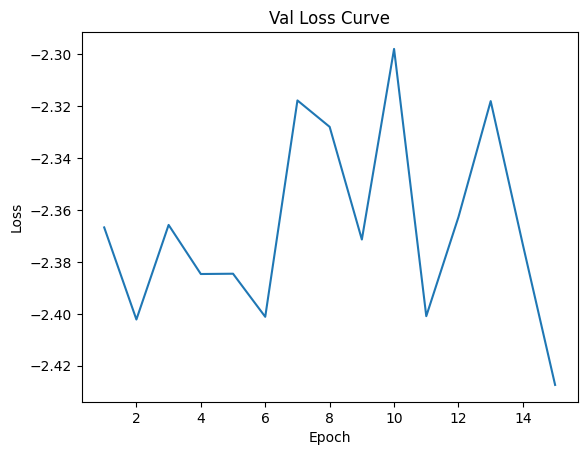

Student weights and architecture saved and exported for lambda: 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 0: loss - 0.6590678137453163


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 1: loss - 0.3952311349703985


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 2: loss - 0.2582274539505734


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.36943252735278187


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.36947409655241403


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.3694651038112009


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 1/100*****
*****Train Loss: -1.111548 Val Loss: -0.189169*****
*****Validation Accuracy: 63.38%*****
*****Total Avg Disparity: 0.15281738285675978*****

Class Team_Sports: Recall Difference = 0.05551468441641849
Class Celebration: Recall Difference = -0.03456640388114013
Class Parade: Recall Difference = 0.0827932504233082
Class Waiter_Or_Waitress: Recall Difference = -0.30612244897959184
Class Individual_Sports: Recall Difference = -0.12168093043669093
Class Surgeons: Recall Difference = -0.1855136733185514
Class Spa: Recall Difference = -0.4539007092198581
Class Law_Enforcement: Recall Difference = 0.006510870828973392
Class Business: Recall Difference = -0.0858908780903666
Class Dresses: Recall Difference = -0.5503067484662577
Class Water Activities: Recall Difference = 0.04070556309362272
Class Picnic: Recall Difference = -0.1830065359477125
Class Rescue: Recall Difference = 0.19898734177215188
Class Cheering: Recall Difference = -0.06464811783960722
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 2/100*****
*****Train Loss: -1.106216 Val Loss: -0.202707*****
*****Validation Accuracy: 63.41%*****
*****Total Avg Disparity: 0.15519476725518067*****

Class Team_Sports: Recall Difference = 0.057534886436620414
Class Celebration: Recall Difference = -0.0512937133616333
Class Parade: Recall Difference = 0.06831318970047295
Class Waiter_Or_Waitress: Recall Difference = -0.2676609105180535
Class Individual_Sports: Recall Difference = -0.10072416063199452
Class Surgeons: Recall Difference = -0.2579453067257944
Class Spa: Recall Difference = -0.4539007092198581
Class Law_Enforcement: Recall Difference = 0.02290431345192412
Class Business: Recall Difference = -0.07715260017050307
Class Dresses: Recall Difference = -0.5380368098159509
Class Water Activities: Recall Difference = 0.04805517865219344
Class Picnic: Recall Difference = -0.18300653594771238
Class Rescue: Recall Difference = 0.19898734177215188
Class Cheering: Recall Difference = -0.09451718494271683
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 3/100*****
*****Train Loss: -1.113978 Val Loss: -0.208928*****
*****Validation Accuracy: 63.41%*****
*****Total Avg Disparity: 0.15534462616516756*****

Class Team_Sports: Recall Difference = 0.07835581245985856
Class Celebration: Recall Difference = -0.07580351728320195
Class Parade: Recall Difference = 0.05243183277865349
Class Waiter_Or_Waitress: Recall Difference = -0.2857142857142859
Class Individual_Sports: Recall Difference = -0.1258137663667619
Class Surgeons: Recall Difference = -0.1611234294161123
Class Spa: Recall Difference = -0.47517730496453897
Class Law_Enforcement: Recall Difference = 0.013603069410533797
Class Business: Recall Difference = -0.07608695652173914
Class Dresses: Recall Difference = -0.5503067484662577
Class Water Activities: Recall Difference = 0.04828132066938018
Class Picnic: Recall Difference = -0.1830065359477125
Class Rescue: Recall Difference = 0.17898734177215192
Class Cheering: Recall Difference = -0.06260229132569556
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 4/100*****
*****Train Loss: -1.105474 Val Loss: -0.160728*****
*****Validation Accuracy: 63.67%*****
*****Total Avg Disparity: 0.14458756855535365*****

Class Team_Sports: Recall Difference = 0.048274654055000865
Class Celebration: Recall Difference = -0.04538103901354362
Class Parade: Recall Difference = 0.046651485957844296
Class Waiter_Or_Waitress: Recall Difference = -0.30612244897959195
Class Individual_Sports: Recall Difference = -0.1078926194133566
Class Surgeons: Recall Difference = -0.13673318551367342
Class Spa: Recall Difference = -0.4539007092198581
Class Law_Enforcement: Recall Difference = 0.049064062318335044
Class Business: Recall Difference = -0.03687127024722936
Class Dresses: Recall Difference = -0.5380368098159509
Class Water Activities: Recall Difference = 0.05563093622795101
Class Picnic: Recall Difference = -0.18300653594771238
Class Rescue: Recall Difference = 0.17367088607594938
Class Cheering: Recall Difference = -0.07119476268412434
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 5/100*****
*****Train Loss: -1.103212 Val Loss: -0.177740*****
*****Validation Accuracy: 63.55%*****
*****Total Avg Disparity: 0.15702165636025014*****

Class Team_Sports: Recall Difference = 0.08155543878087224
Class Celebration: Recall Difference = -0.06989084293511216
Class Parade: Recall Difference = 0.035090792316225805
Class Waiter_Or_Waitress: Recall Difference = -0.30612244897959184
Class Individual_Sports: Recall Difference = -0.11506107819471878
Class Surgeons: Recall Difference = -0.2032520325203252
Class Spa: Recall Difference = -0.4539007092198581
Class Law_Enforcement: Recall Difference = 0.03487966515521468
Class Business: Recall Difference = -0.10656436487638538
Class Dresses: Recall Difference = -0.5441717791411044
Class Water Activities: Recall Difference = 0.04093170511080979
Class Picnic: Recall Difference = -0.1830065359477125
Class Rescue: Recall Difference = 0.16430379746835455
Class Cheering: Recall Difference = -0.07528641571194761
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 6/100*****
*****Train Loss: -1.106177 Val Loss: -0.196778*****
*****Validation Accuracy: 63.46%*****
*****Total Avg Disparity: 0.15358982506994684*****

Class Team_Sports: Recall Difference = 0.07487592689904832
Class Celebration: Recall Difference = -0.05417424701839507
Class Parade: Recall Difference = 0.04233082267764354
Class Waiter_Or_Waitress: Recall Difference = -0.30612244897959195
Class Individual_Sports: Recall Difference = -0.11147684880403763
Class Surgeons: Recall Difference = -0.1367331855136733
Class Spa: Recall Difference = -0.47517730496453897
Class Law_Enforcement: Recall Difference = 0.03487966515521446
Class Business: Recall Difference = -0.0858908780903666
Class Dresses: Recall Difference = -0.5441717791411044
Class Water Activities: Recall Difference = 0.04070556309362283
Class Picnic: Recall Difference = -0.1830065359477125
Class Rescue: Recall Difference = 0.1663291139240506
Class Cheering: Recall Difference = -0.08081014729950892
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 7/100*****
*****Train Loss: -1.116627 Val Loss: -0.185046*****
*****Validation Accuracy: 63.67%*****
*****Total Avg Disparity: 0.15863501358632745*****

Class Team_Sports: Recall Difference = 0.08413615928066775
Class Celebration: Recall Difference = -0.07918940772185157
Class Parade: Recall Difference = 0.04519180241723586
Class Waiter_Or_Waitress: Recall Difference = -0.2959183673469389
Class Individual_Sports: Recall Difference = -0.10430839002267567
Class Surgeons: Recall Difference = -0.14855875831485588
Class Spa: Recall Difference = -0.4539007092198581
Class Law_Enforcement: Recall Difference = 0.027787466573654274
Class Business: Recall Difference = -0.11636828644501285
Class Dresses: Recall Difference = -0.5503067484662577
Class Water Activities: Recall Difference = 0.06320669380370869
Class Picnic: Recall Difference = -0.27450980392156854
Class Rescue: Recall Difference = 0.12632911392405055
Class Cheering: Recall Difference = -0.06260229132569556
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 8/100*****
*****Train Loss: -1.118237 Val Loss: -0.199421*****
*****Validation Accuracy: 63.35%*****
*****Total Avg Disparity: 0.15043497152529905*****

Class Team_Sports: Recall Difference = 0.07055526361884723
Class Celebration: Recall Difference = -0.0448756822316555
Class Parade: Recall Difference = 0.03077012903602505
Class Waiter_Or_Waitress: Recall Difference = -0.2857142857142857
Class Individual_Sports: Recall Difference = -0.12884938921805278
Class Surgeons: Recall Difference = -0.16703621581670347
Class Spa: Recall Difference = -0.4539007092198581
Class Law_Enforcement: Recall Difference = 0.027787466573654274
Class Business: Recall Difference = -0.09676044330775796
Class Dresses: Recall Difference = -0.5503067484662577
Class Water Activities: Recall Difference = 0.05563093622795112
Class Picnic: Recall Difference = -0.1830065359477125
Class Rescue: Recall Difference = 0.1663291139240506
Class Cheering: Recall Difference = -0.07324058919803605
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 9/100*****
*****Train Loss: -1.120401 Val Loss: -0.206389*****
*****Validation Accuracy: 63.75%*****
*****Total Avg Disparity: 0.15956969863414855*****

Class Team_Sports: Recall Difference = 0.0615752904770247
Class Celebration: Recall Difference = -0.0688801293713362
Class Parade: Recall Difference = 0.04233082267764354
Class Waiter_Or_Waitress: Recall Difference = -0.30612244897959195
Class Individual_Sports: Recall Difference = -0.1186453075853997
Class Surgeons: Recall Difference = -0.1611234294161123
Class Spa: Recall Difference = -0.47517730496453897
Class Law_Enforcement: Recall Difference = 0.057900244157656156
Class Business: Recall Difference = -0.07608695652173914
Class Dresses: Recall Difference = -0.5564417177914109
Class Water Activities: Recall Difference = 0.05563093622795101
Class Picnic: Recall Difference = -0.1830065359477125
Class Rescue: Recall Difference = 0.21898734177215184
Class Cheering: Recall Difference = -0.042348608837970536
Class Performance_A

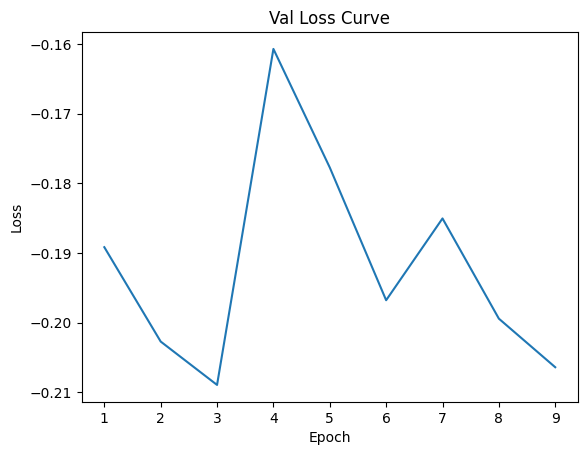

Student weights and architecture saved and exported for lambda: 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 0: loss - 0.6642084483276395


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 1: loss - 0.39376580474131245


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 2: loss - 0.256318386644125


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.33764281200573726


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.3376853633671999


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.3375582159222925


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 1/100*****
*****Train Loss: -0.328839 Val Loss:  0.249041*****
*****Validation Accuracy: 64.85%*****
*****Total Avg Disparity: 0.1567079604912734*****

Class Team_Sports: Recall Difference = 0.09092076837741558
Class Celebration: Recall Difference = 0.049777643015969264
Class Parade: Recall Difference = 0.10305365796695276
Class Waiter_Or_Waitress: Recall Difference = -0.2778649921507065
Class Individual_Sports: Recall Difference = -0.018835491185721698
Class Surgeons: Recall Difference = -0.12416851441241683
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.19218695500523186
Class Business: Recall Difference = 0.01747655583972707
Class Dresses: Recall Difference = -0.6159509202453988
Class Water Activities: Recall Difference = 0.048055178652193664
Class Picnic: Recall Difference = -0.23529411764705882
Class Rescue: Recall Difference = 0.039746835443037976
Class Cheering: Recall Difference = -0.13461538461538458
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 2/100*****
*****Train Loss: -0.341417 Val Loss:  0.251728*****
*****Validation Accuracy: 65.25%*****
*****Total Avg Disparity: 0.1577948016564224*****

Class Team_Sports: Recall Difference = 0.10220120277923728
Class Celebration: Recall Difference = 0.05518496058217104
Class Parade: Recall Difference = 0.0813919542243241
Class Waiter_Or_Waitress: Recall Difference = -0.28806907378335955
Class Individual_Sports: Recall Difference = -0.025455343427693622
Class Surgeons: Recall Difference = -0.07538802660753874
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.19218695500523197
Class Business: Recall Difference = 0.03601875532821819
Class Dresses: Recall Difference = -0.6159509202453988
Class Water Activities: Recall Difference = 0.04850746268656736
Class Picnic: Recall Difference = -0.2745098039215687
Class Rescue: Recall Difference = 0.05974683544303799
Class Cheering: Recall Difference = -0.15384615384615385
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 3/100*****
*****Train Loss: -0.327977 Val Loss:  0.255642*****
*****Validation Accuracy: 64.76%*****
*****Total Avg Disparity: 0.14742077734854625*****

Class Team_Sports: Recall Difference = 0.09816079873883332
Class Celebration: Recall Difference = 0.0286537295330504
Class Parade: Recall Difference = 0.05827056694108712
Class Waiter_Or_Waitress: Recall Difference = -0.2778649921507065
Class Individual_Sports: Recall Difference = -0.04337649038109859
Class Surgeons: Recall Difference = -0.12416851441241683
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.17579351238228091
Class Business: Recall Difference = -0.013000852514919004
Class Dresses: Recall Difference = -0.6098159509202454
Class Water Activities: Recall Difference = 0.010854816824966251
Class Picnic: Recall Difference = -0.2745098039215686
Class Rescue: Recall Difference = 0.014430379746835476
Class Cheering: Recall Difference = -0.1143617021276595
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 4/100*****
*****Train Loss: -0.327750 Val Loss:  0.231869*****
*****Validation Accuracy: 64.76%*****
*****Total Avg Disparity: 0.1562938162299948*****

Class Team_Sports: Recall Difference = 0.09322122963741475
Class Celebration: Recall Difference = -0.02779462300384078
Class Parade: Recall Difference = 0.06983126058270561
Class Waiter_Or_Waitress: Recall Difference = -0.2778649921507065
Class Individual_Sports: Recall Difference = -0.035110818520956766
Class Surgeons: Recall Difference = -0.12416851441241683
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.1337053830949888
Class Business: Recall Difference = -0.02280477408354642
Class Dresses: Recall Difference = -0.703680981595092
Class Water Activities: Recall Difference = 0.048733604703754096
Class Picnic: Recall Difference = -0.29411764705882354
Class Rescue: Recall Difference = -0.020253164556962022
Class Cheering: Recall Difference = -0.11436170212765967
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 5/100*****
*****Train Loss: -0.328443 Val Loss:  0.247070*****
*****Validation Accuracy: 64.44%*****
*****Total Avg Disparity: 0.15634624940542613*****

Class Team_Sports: Recall Difference = 0.07790039119518888
Class Celebration: Recall Difference = -0.013088740650899544
Class Parade: Recall Difference = 0.0756116074035148
Class Waiter_Or_Waitress: Recall Difference = -0.2778649921507065
Class Individual_Sports: Recall Difference = -0.05442176870748294
Class Surgeons: Recall Difference = -0.12416851441241683
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.16870131380072095
Class Business: Recall Difference = 0.007672634271099765
Class Dresses: Recall Difference = -0.7098159509202453
Class Water Activities: Recall Difference = 0.02578018995929454
Class Picnic: Recall Difference = -0.25490196078431376
Class Rescue: Recall Difference = 0.039746835443037976
Class Cheering: Recall Difference = -0.14423076923076922
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.42it/s]


*****Epoch 6/100*****
*****Train Loss: -0.335747 Val Loss:  0.277422*****
*****Validation Accuracy: 64.79%*****
*****Total Avg Disparity: 0.15413051492490973*****

Class Team_Sports: Recall Difference = 0.08805978863782349
Class Celebration: Recall Difference = 0.04927228623408125
Class Parade: Recall Difference = 0.11029368832837028
Class Waiter_Or_Waitress: Recall Difference = -0.28806907378335955
Class Individual_Sports: Recall Difference = -0.049996342623070844
Class Surgeons: Recall Difference = -0.12416851441241683
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.1594000697593303
Class Business: Recall Difference = 0.025149190110826947
Class Dresses: Recall Difference = -0.6098159509202452
Class Water Activities: Recall Difference = 0.048733604703754096
Class Picnic: Recall Difference = -0.25490196078431376
Class Rescue: Recall Difference = -0.025569620253164504
Class Cheering: Recall Difference = -0.09206219312602287
Class Performa

 76%|██████████████████████████████████████████████████████████████████▋                     | 103/136 [01:02<00:19,  1.68it/s]

In [ ]:
lambda_results = {}
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_ckd_wider_lambda02.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda02.pth'))
    
    # Reset the student model for each lambda
    student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
    student_model.classifier = nn.Linear(1280, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)
    
    if i != 0:
        pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
        pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, 
                                                                               adv_criterion, student_optimizer_adv, student_optimizer_adv, device, alpha, 
                                                                               temperature, epochs, lmda=i, patience=patience_student)

    torch.save(student_model.state_dict(), f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_ckd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Update the dictionary with the student results
    if i in lambda_results:
        # If the key 'i' is already present in the dictionary
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })
    else:
        # If the key 'i' is not present in the dictionary
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }

In [ ]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

In [ ]:
# Loop through each lambda value
for lmda in lmda_list_student:
    # Load teacher and student models for the current lambda
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda02.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Compute performance metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

    # Compute model sizes and inference times
    teacher_params, student_params = compare_model_size(teacher_model, student_model)
    teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

    # Update results for the current lambda value
    if lmda in lambda_results:
        lambda_results[lmda].update({
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        })
    else:
        lambda_results[lmda] = {
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        }


In [ ]:
lambdas = list(lambda_results.keys())
teacher_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][0] for lmda in lambdas]
student_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][1] for lmda in lambdas]

plt.plot(lambdas, teacher_accuracies, label='Teacher Accuracy', marker='o')
plt.plot(lambdas, student_accuracies, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Precision
teacher_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][0] for lmda in lambdas]
student_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_precisions, label='Teacher Precision', marker='o')
plt.plot(lambdas, student_precisions, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Recall
teacher_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][0] for lmda in lambdas]
student_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_recalls, label='Teacher Recall', marker='o')
plt.plot(lambdas, student_recalls, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# F1 Score
teacher_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][0] for lmda in lambdas]
student_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_f1s, label='Teacher F1 Score', marker='o')
plt.plot(lambdas, student_f1s, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Model Size
teacher_sizes = [lambda_results[lmda]['teacher_params'] / 1e6 for lmda in lambdas]  # Convert to millions
student_sizes = [lambda_results[lmda]['student_params'] / 1e6 for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_sizes, label='Teacher Model Size', marker='o')
plt.plot(lambdas, student_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Inference Time
teacher_times = [lambda_results[lmda]['teacher_time'] for lmda in lambdas]
student_times = [lambda_results[lmda]['student_time'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_times, label='Teacher Inference Time', marker='o')
plt.plot(lambdas, student_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Extracting disparity values for both teacher and student models
student_disparities = [lambda_results[lmda]['student_mean_abs_val_disparity'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, student_disparities, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
lambda_results

In [ ]:
def plot_combined_distribution(teacher_preds, student_preds, class_names, lmda):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=teacher_preds)
    plt.title(f'Teacher Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)

    plt.subplot(1, 2, 2)
    sns.countplot(x=student_preds)
    plt.title(f'Student Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_combined_confusion_matrix(all_labels, teacher_preds, student_preds, class_names, lmda):
    cm_teacher = confusion_matrix(all_labels, teacher_preds)
    cm_student = confusion_matrix(all_labels, student_preds)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(pd.DataFrame(cm_teacher, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Teacher Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(1, 2, 2)
    sns.heatmap(pd.DataFrame(cm_student, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Student Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Loop over each lambda value
for lmda in lmda_list_student:
    # Load teacher and student models
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda02.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Generate predictions and compute metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    all_labels = performance_metrics['all_labels']
    all_teacher_preds = performance_metrics['all_teacher_preds']
    all_student_preds = performance_metrics['all_student_preds']

    # Plot distribution and confusion matrices
    plot_combined_distribution(all_teacher_preds, all_student_preds, class_names_new, lmda)
    plot_combined_confusion_matrix(all_labels, all_teacher_preds, all_student_preds, class_names_new, lmda)

    # Print classification reports
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda})')
    print(teacher_report)
    print(f'Classification Report - Student Model (Lambda={lmda})')
    print(student_report)


In [ ]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    # Extract bias (disparity) and accuracy values
    if model_type == 'teacher':
        bias_values = [result['teacher_mean_abs_val_disparity'][0] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][0] for result in model_results.values()]
        model_name = "Teacher"
    elif model_type == 'student':
        bias_values = [result['student_mean_abs_val_disparity'] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][1] for result in model_results.values()]
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")

    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")

# Plot for Teacher
# plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)


In [ ]:
def get_disparities_accuracies(lmda, dataloader):
    model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')
    total_samples = 0
    total_correct = 0
    num_batches = 0.0
    confusion_male = 0
    confusion_female = 0
    val_accuracies = []
    val_disparities = []
    with torch.no_grad():
        for val_data in tqdm(testloader):
            val_inputs = val_data['img'].to(device)
            val_labels = val_data['label'].to(device)
            val_targets = val_data['target'].to(device)

            # Forward pass for validation
            val_student_outputs = model(val_inputs)   


            # Compute the validation accuracy
            _, predicted = torch.max(val_student_outputs, 1)
            total_samples += val_labels.size(0)
            total_correct += (predicted == val_labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]

        confusion_male  = confusion_male/num_batches
        confusion_female = confusion_female/num_batches

        epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
        mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
        val_disparities.append(mean_non_zero_abs_disparity)
        accuracy = total_correct / total_samples
        val_accuracies.append(accuracy)
        print(f'Lambda: {lmda}'
        f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
        f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}

        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Recall Difference = {recall_diff}")

In [ ]:
for i in lmda_list_student:
    get_disparities_accuracies(i, testloader)